<a href="https://colab.research.google.com/github/Laaliji/Books_Recommandation_System/blob/main/Clustering_Based_Recommandation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd  # Pour gérer les datasets sous forme de DataFrames
import numpy as np   # Pour les opérations numériques et la gestion des tableaux
# Importation des modules scikit-learn pour les tâches d'apprentissage automatique
from sklearn.cluster import KMeans  # Pour le clustering K-Means
from sklearn.decomposition import PCA  # Pour la réduction de dimensionnalité
from sklearn.metrics import precision_score, recall_score, mean_absolute_error  # Pour les métriques d'évaluation
from sklearn.model_selection import KFold  # Pour la validation croisée
from sklearn.metrics.pairwise import cosine_distances  # Pour calculer la métrique de diversité
import seaborn as sns
from collections import Counter
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import csv
import os
from scipy.sparse import csr_matrix
# Importation de scipy pour les opérations sur matrices creuses
from scipy.sparse import csr_matrix  # Pour une représentation efficace des matrices creuses
# Importation de matplotlib pour la visualisation
import matplotlib.pyplot as plt  # Pour tracer les visualisations des clusters

# Montage de Google Drive pour accéder au dataset
from google.colab import drive
drive.mount('/content/drive')
# Définition du chemin de base pour le dataset
base_path = '/content/drive/My Drive/Movies Dataset/'
contents = os.listdir(base_path)
print(contents)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['genome_scores.csv', 'movie.csv', 'rating.csv', 'link.csv', 'genome_tags.csv', 'tag.csv']


In [13]:
try:
    # First, let's inspect the movie.csv file to determine the correct delimiter
    with open(base_path + 'movie.csv', 'r', encoding='utf-8') as file:
        sample = file.read(1000)  # Read first 1000 characters to detect format
        print("Sample of movie.csv file:")
        print(sample)

    # Try loading with comma as delimiter first (most common)
    try:
        movie_df = pd.read_csv(base_path + 'movie.csv',
                              quoting=csv.QUOTE_MINIMAL,
                              escapechar='\\',
                              encoding='utf-8')
        print("Successfully loaded movie.csv using comma as delimiter")
    except Exception as e:
        print(f"Error with comma delimiter: {e}")
        # If comma doesn't work, try with semicolon and additional options
        movie_df = pd.read_csv(base_path + 'movie.csv',
                              sep=';',
                              quoting=csv.QUOTE_MINIMAL,
                              escapechar='\\',
                              encoding='utf-8',
                              error_bad_lines=False)  # Skip problematic lines

    # Try to load other files with appropriate settings
    genome_scores_df = pd.read_csv(base_path + 'genome_scores.csv')
    genome_tags_df = pd.read_csv(base_path + 'genome_tags.csv')
    links_df = pd.read_csv(base_path + 'link.csv')
    ratings_df = pd.read_csv(base_path + 'rating.csv')
    tag_df = pd.read_csv(base_path + 'tag.csv')

    # Configuration de la graine aléatoire pour la reproductibilité
    np.random.seed(42)

except FileNotFoundError as e:
    print(f"Erreur : Fichiers du dataset non trouvés. {e}")
    print("Vérifiez le base_path et assurez-vous que les fichiers existent.")
except Exception as e:
    print(f"Une erreur inattendue s'est produite: {e}")

Sample of movie.csv file:
"movieId","title","genres"
1,"Toy Story (1995)","Adventure|Animation|Children|Comedy|Fantasy"
2,"Jumanji (1995)","Adventure|Children|Fantasy"
3,"Grumpier Old Men (1995)","Comedy|Romance"
4,"Waiting to Exhale (1995)","Comedy|Drama|Romance"
5,"Father of the Bride Part II (1995)","Comedy"
6,"Heat (1995)","Action|Crime|Thriller"
7,"Sabrina (1995)","Comedy|Romance"
8,"Tom and Huck (1995)","Adventure|Children"
9,"Sudden Death (1995)","Action"
10,"GoldenEye (1995)","Action|Adventure|Thriller"
11,"American President, The (1995)","Comedy|Drama|Romance"
12,"Dracula: Dead and Loving It (1995)","Comedy|Horror"
13,"Balto (1995)","Adventure|Animation|Children"
14,"Nixon (1995)","Drama"
15,"Cutthroat Island (1995)","Action|Adventure|Romance"
16,"Casino (1995)","Crime|Drama"
17,"Sense and Sensibility (1995)","Drama|Romance"
18,"Four Rooms (1995)","Comedy"
19,"Ace Ventura: When Nature Calls (1995)","Comedy"
20,"Money Train (1995)","Action|Comedy|Crime|Drama|Thriller"
21,"Get S

In [15]:
# Print basic information for each DataFrame
for df, name in [(movie_df, "Movies"), (ratings_df, "Ratings"), (tag_df, "Tags"),
                 (genome_scores_df, "Genome Scores"), (genome_tags_df, "Genome Tags"),
                 (links_df, "Links")]:
    print(f"\n{'-'*50}")
    print(f"{name} DataFrame Analysis:")
    print(f"{'-'*50}")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSample Data:")
    print(df.head())
    print()  # Add spacing between DataFrames


--------------------------------------------------
Movies DataFrame Analysis:
--------------------------------------------------
Shape: (27278, 3)

Data Types:
movieId     int64
title      object
genres     object
dtype: object

Missing Values:
movieId    0
title      0
genres     0
dtype: int64

Sample Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


--------------------------------------------------
Ratings DataFrame Analysis:
------------


=== MOVIE ANALYSIS ===


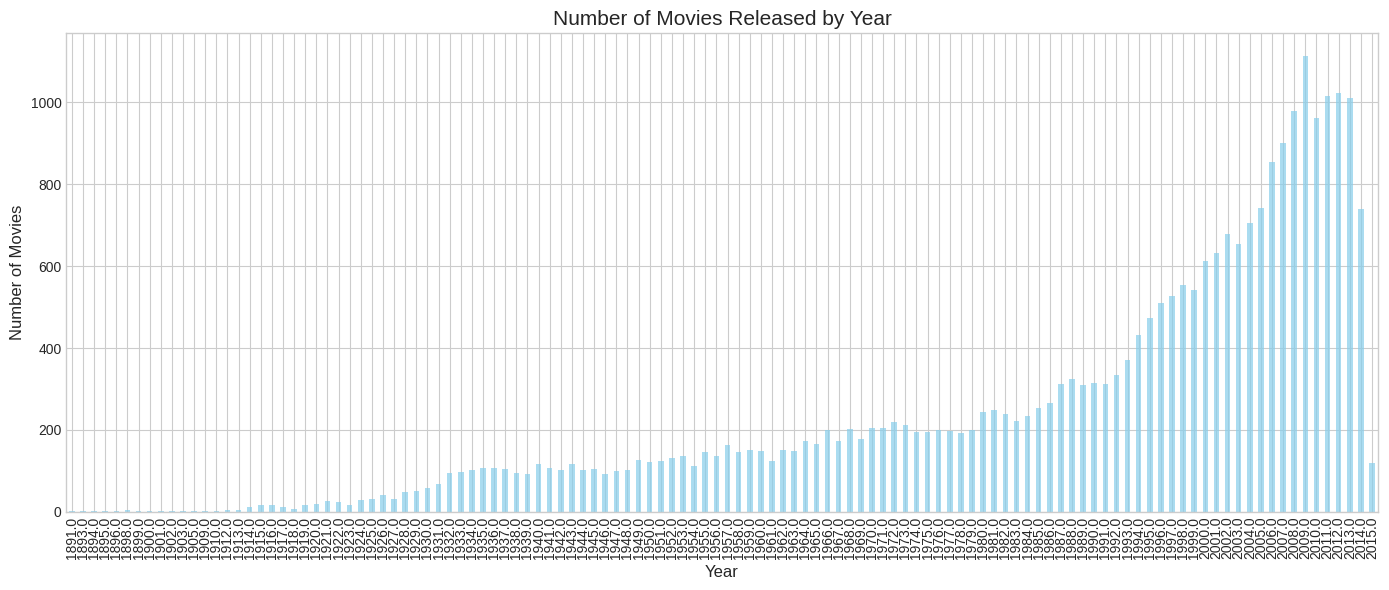

<Figure size 1400x600 with 0 Axes>

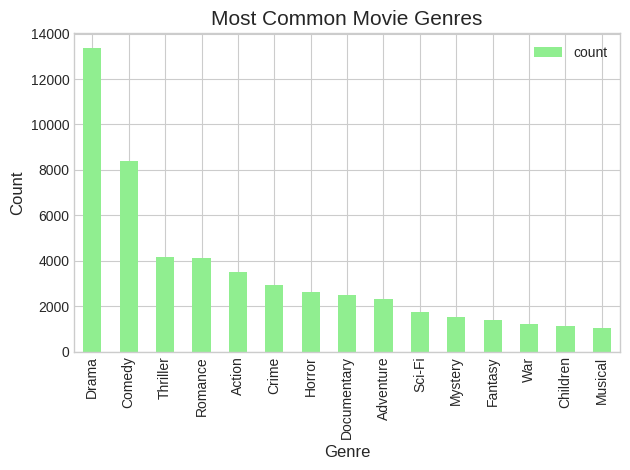

In [16]:
# Movie Analysis
print("\n=== MOVIE ANALYSIS ===")

# Extract year from title and create a new column
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Count genres
all_genres = []
for genres in movie_df['genres'].str.split('|'):
    if isinstance(genres, list):  # Check if genres is a list (not NaN)
        all_genres.extend(genres)

genres_count = Counter(all_genres)

# Plot movie distribution by year
plt.figure(figsize=(14, 6))
movie_df['year'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Number of Movies Released by Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot top genres
plt.figure(figsize=(14, 6))
genres_df = pd.DataFrame.from_dict(genres_count, orient='index', columns=['count'])
genres_df = genres_df.sort_values('count', ascending=False)
genres_df.head(15).plot(kind='bar', color='lightgreen')
plt.title('Most Common Movie Genres', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


=== RATINGS ANALYSIS ===

Ratings Distribution:
count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


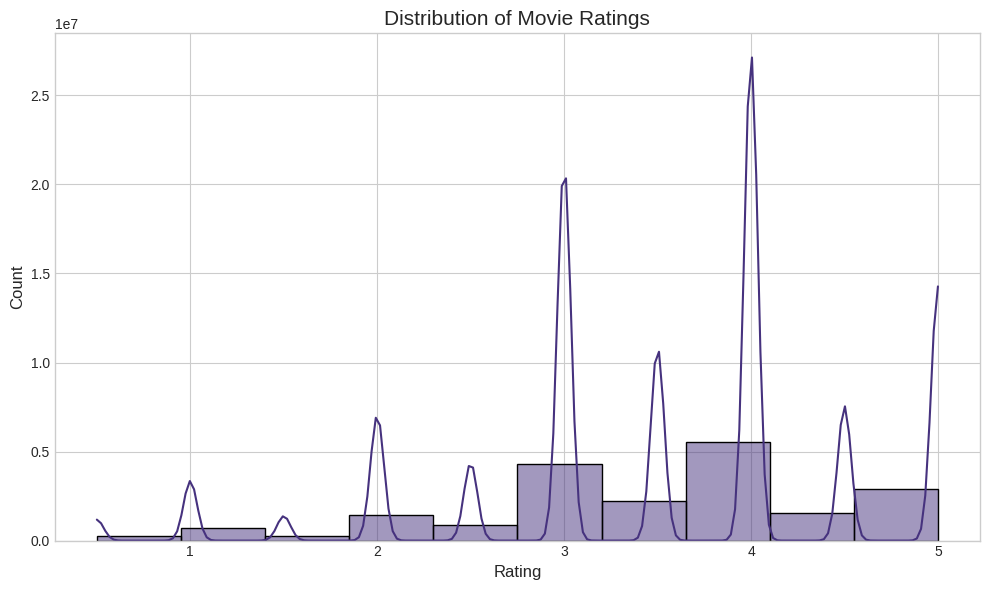

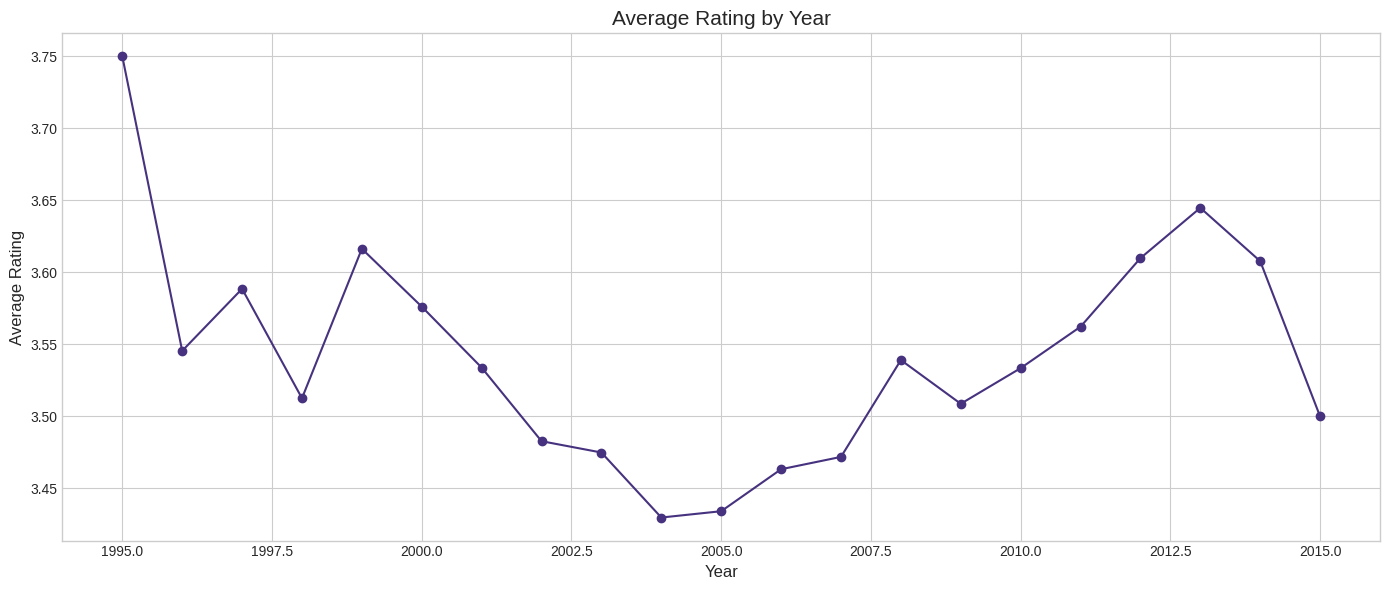

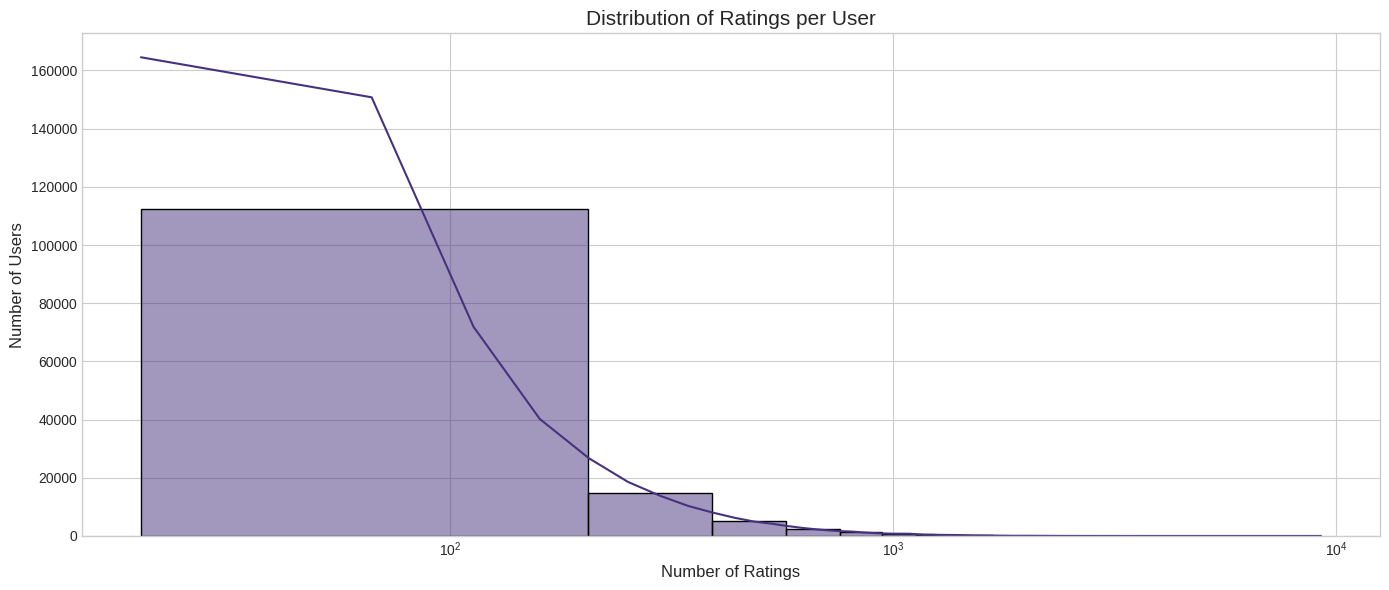

In [17]:
# Ratings Analysis
print("\n=== RATINGS ANALYSIS ===")

# Basic stats for ratings
print("\nRatings Distribution:")
print(ratings_df['rating'].describe())

# Convert timestamp to datetime
if ratings_df['timestamp'].dtype in [np.int64, np.float64]:
    ratings_df['datetime'] = ratings_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
else:
    ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'])

# Add year and month columns
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df['month'] = ratings_df['datetime'].dt.month

# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Plot ratings over time (yearly)
yearly_ratings = ratings_df.groupby('year')['rating'].mean()
plt.figure(figsize=(14, 6))
yearly_ratings.plot(marker='o', linestyle='-')
plt.title('Average Rating by Year', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# User activity distribution
plt.figure(figsize=(14, 6))
user_rating_counts = ratings_df['userId'].value_counts()
sns.histplot(user_rating_counts, bins=50, kde=True)
plt.title('Distribution of Ratings per User', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xscale('log')
plt.tight_layout()
plt.show()


=== TAGS ANALYSIS ===
Number of unique tags: 38643

Top 20 Tags:
tag
sci-fi                3384
based on a book       3281
atmospheric           2917
comedy                2779
action                2657
surreal               2427
BD-R                  2334
twist ending          2323
funny                 2072
dystopia              1991
stylized              1941
quirky                1906
dark comedy           1899
classic               1769
psychology            1754
fantasy               1703
time travel           1549
romance               1534
visually appealing    1509
disturbing            1487
Name: count, dtype: int64


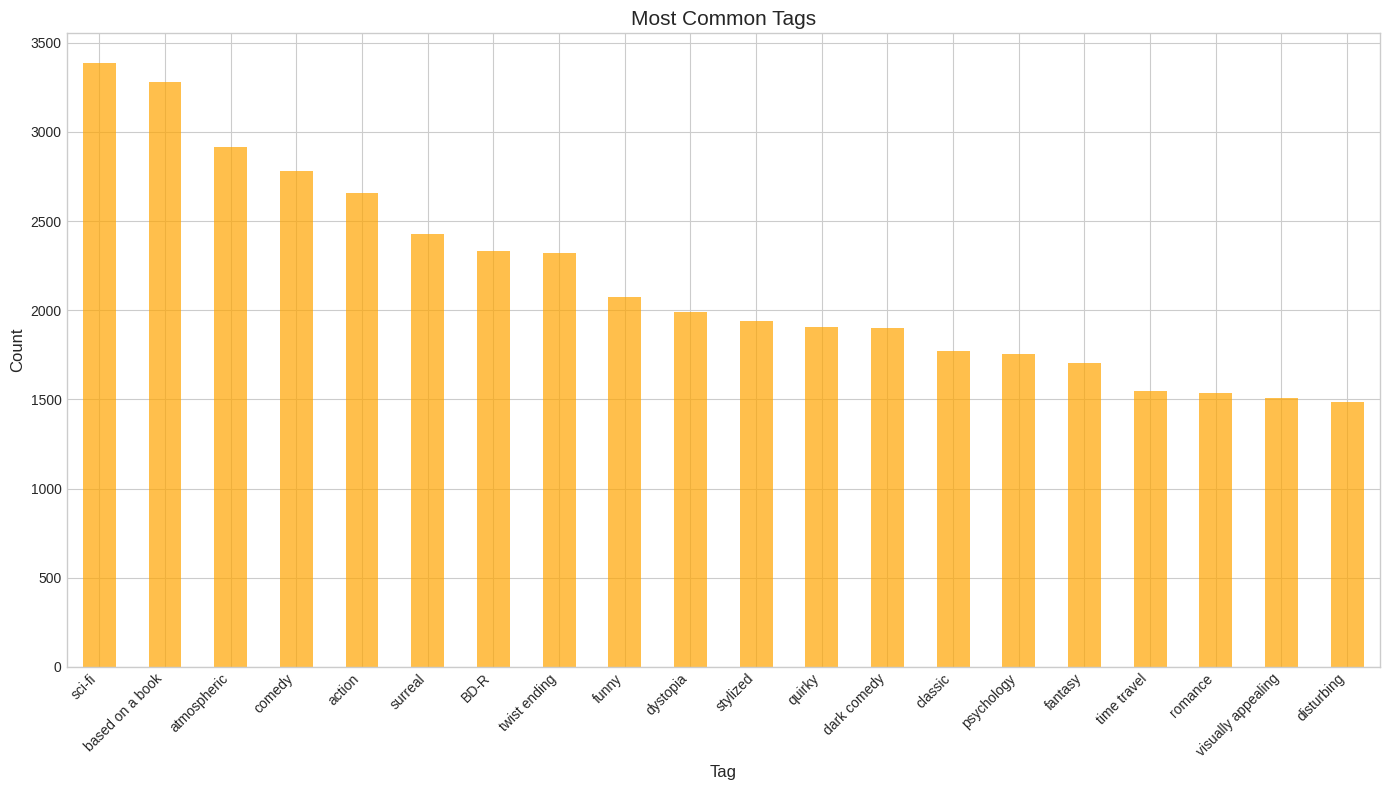

In [18]:
# Tags Analysis
print("\n=== TAGS ANALYSIS ===")

# Count number of unique tags
unique_tags = tag_df['tag'].nunique()
print(f"Number of unique tags: {unique_tags}")

# Top tags
top_tags = tag_df['tag'].value_counts().head(20)
print("\nTop 20 Tags:")
print(top_tags)

# Plot top tags
plt.figure(figsize=(14, 8))
top_tags.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Most Common Tags', fontsize=15)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


=== GENOME ANALYSIS ===


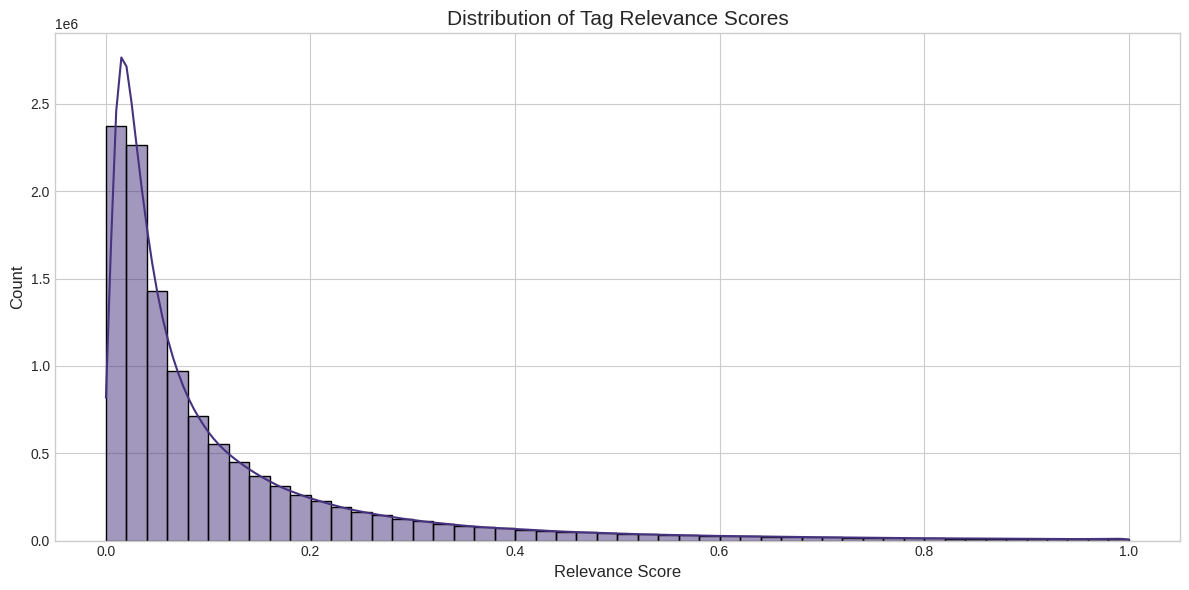


Top 20 Tags by Average Relevance:
tag
original           0.730527
mentor             0.530233
great ending       0.499534
dialogue           0.490878
good soundtrack    0.455614
catastrophe        0.450997
storytelling       0.448479
story              0.427058
great              0.426717
good               0.424800
runaway            0.416895
brutality          0.408840
culture clash      0.390786
criterion          0.388207
life philosophy    0.386411
melancholic        0.385292
pornography        0.381285
destiny            0.376464
adaptation         0.373611
talky              0.361232
Name: relevance, dtype: float64


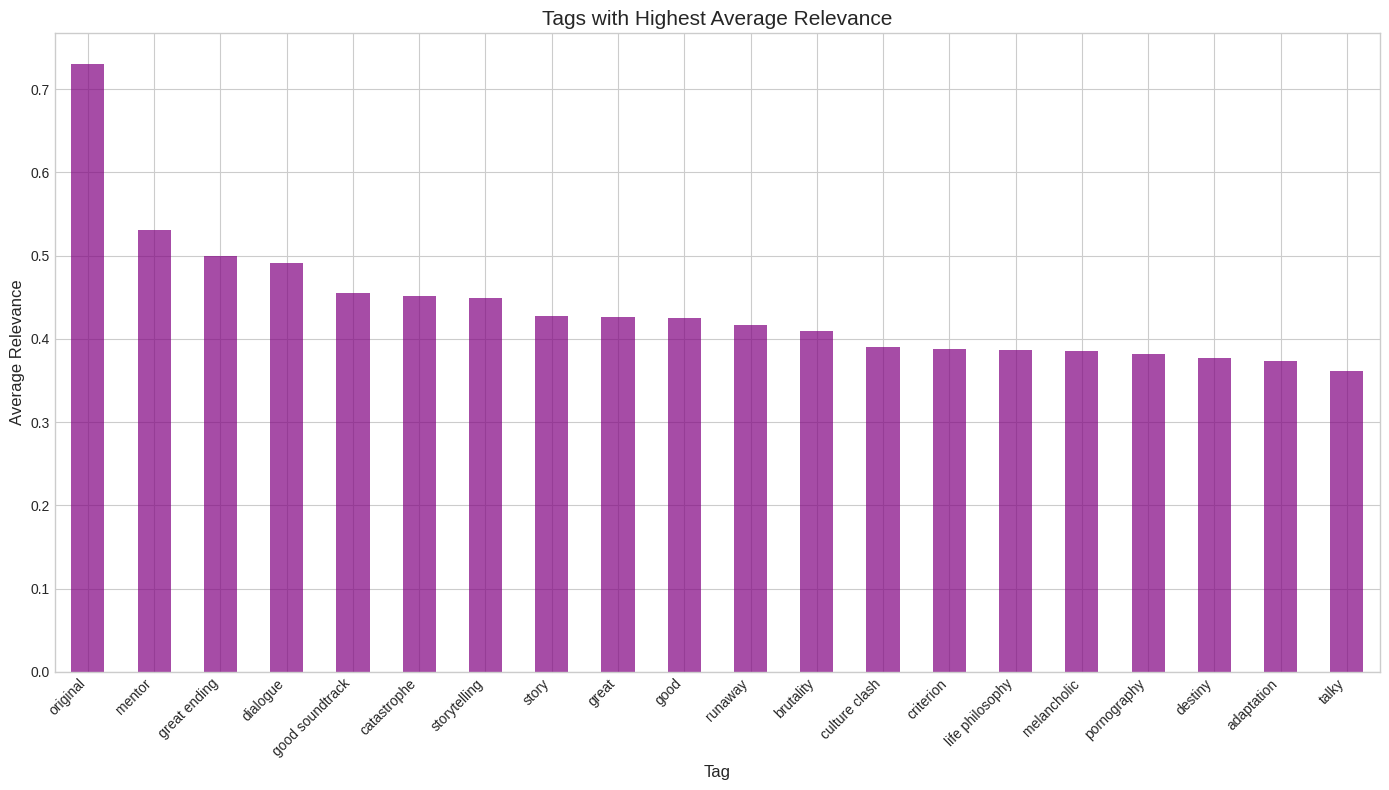

In [19]:
# Genome Analysis
print("\n=== GENOME ANALYSIS ===")

# Merge genome data
genome_df = pd.merge(genome_scores_df, genome_tags_df, on='tagId')

# Distribution of relevance scores
plt.figure(figsize=(12, 6))
sns.histplot(genome_df['relevance'], bins=50, kde=True)
plt.title('Distribution of Tag Relevance Scores', fontsize=15)
plt.xlabel('Relevance Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Top tags by average relevance
tag_relevance = genome_df.groupby('tag')['relevance'].mean().sort_values(ascending=False)
print("\nTop 20 Tags by Average Relevance:")
print(tag_relevance.head(20))

# Plot top relevant tags
plt.figure(figsize=(14, 8))
tag_relevance.head(20).plot(kind='bar', color='purple', alpha=0.7)
plt.title('Tags with Highest Average Relevance', fontsize=15)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Average Relevance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


=== POPULAR MOVIES ===

Top 20 Movies (with at least 100 ratings):
                                                title  mean_rating  \
0                    Shawshank Redemption, The (1994)     4.446990   
1                               Godfather, The (1972)     4.364732   
2                          Usual Suspects, The (1995)     4.334372   
3                             Schindler's List (1993)     4.310175   
4                      Godfather: Part II, The (1974)     4.275641   
5         Seven Samurai (Shichinin no samurai) (1954)     4.274180   
6                                  Rear Window (1954)     4.271334   
7                             Band of Brothers (2001)     4.263182   
8                                   Casablanca (1942)     4.258327   
9       Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)     4.256935   
10             One Flew Over the Cuckoo's Nest (1975)     4.248079   
11  Dr. Strangelove or: How I Learned to Stop Worr...     4.247287   
12                    

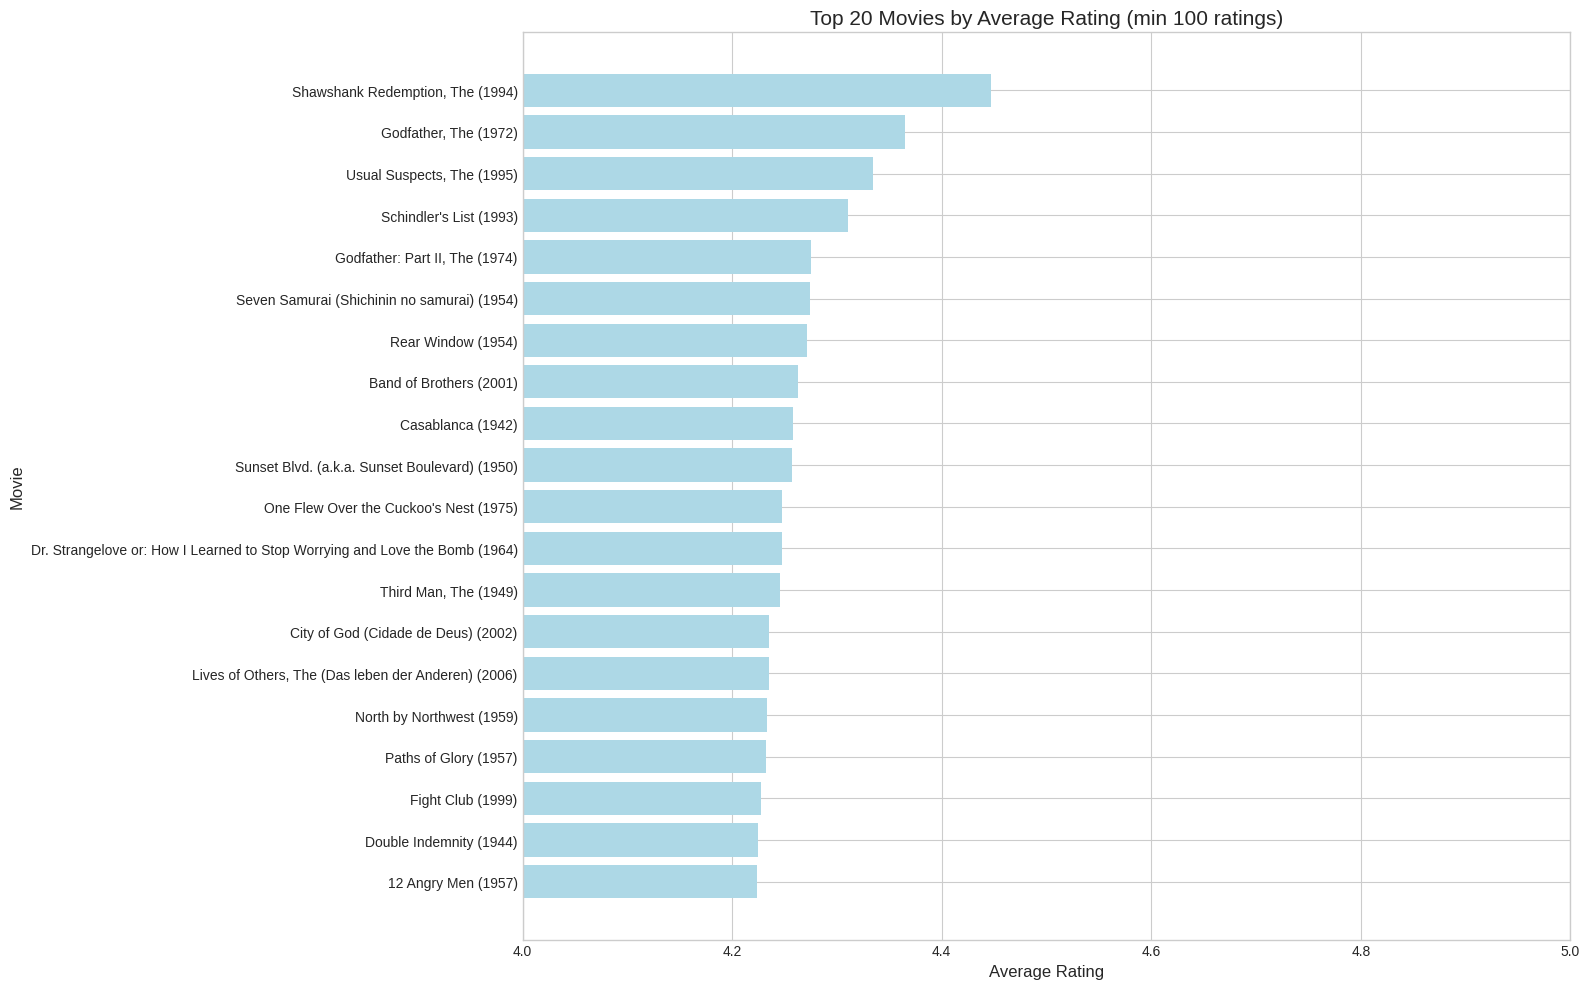

In [20]:
# Popular Movies Analysis
print("\n=== POPULAR MOVIES ===")

# Group by movieId and calculate stats
movie_stats = ratings_df.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Filter movies with a minimum number of ratings
min_ratings = 100
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]
popular_movies = popular_movies.sort_values('mean_rating', ascending=False)

# Merge with movie data
popular_movies = pd.merge(popular_movies, movie_df[['movieId', 'title']], on='movieId')

# Print top 20 movies
print(f"\nTop 20 Movies (with at least {min_ratings} ratings):")
print(popular_movies[['title', 'mean_rating', 'num_ratings']].head(20))

# Plot top 20 movies
plt.figure(figsize=(16, 10))
top20 = popular_movies.head(20)
plt.barh(top20['title'], top20['mean_rating'], color='lightblue')
plt.title(f'Top 20 Movies by Average Rating (min {min_ratings} ratings)', fontsize=15)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Movie', fontsize=12)
plt.xlim(4, 5)  # Adjust based on data (MovieLens ratings are typically 0.5–5.0)
plt.gca().invert_yaxis()  # Highest rated at the top
plt.tight_layout()
plt.show()

In [24]:
# Clean Movies DataFrame
print("\n=== Cleaning Movies DataFrame ===")

# Extract year from title
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)
print(f"Missing years: {movie_df['year'].isnull().sum()}")
# Impute missing years with median
median_year = movie_df['year'].median()
movie_df['year'] = movie_df['year'].fillna(median_year)
print(f"Missing years after imputation: {movie_df['year'].isnull().sum()}")

# Replace '(no genres listed)' with 'Unknown'
movie_df['genres'] = movie_df['genres'].replace('(no genres listed)', 'Unknown')

# Clean titles (strip spaces)
movie_df['title'] = movie_df['title'].str.strip()

# Check for duplicate titles
duplicate_titles = movie_df[movie_df['title'].duplicated(keep=False)]
print(f"Duplicate titles found: {len(duplicate_titles)}")
if len(duplicate_titles) > 0:
    print("Sample duplicate titles:")
    print(duplicate_titles[['movieId', 'title']].head())

# Create genres list and one-hot encode
movie_df['genres_list'] = movie_df['genres'].str.split('|')
genres_unique = set()
for genres in movie_df['genres_list']:
    genres_unique.update(genres)
genres_unique = sorted(genres_unique)
for genre in genres_unique:
    movie_df[f'genre_{genre}'] = movie_df['genres_list'].apply(lambda x: 1 if genre in x else 0)
print(f"Genres encoded: {genres_unique}")


=== Cleaning Movies DataFrame ===
Missing years: 22
Missing years after imputation: 0
Duplicate titles found: 32
Sample duplicate titles:
      movieId                 title
582       588        Aladdin (1992)
823       838           Emma (1996)
1716     1788  Men with Guns (1997)
3507     3598         Hamlet (2000)
9135    26958           Emma (1996)
Genres encoded: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Unknown', 'War', 'Western']


In [25]:
# Clean Tags DataFrame
print("\n=== Cleaning Tags DataFrame ===")

# Handle missing tags
print(f"Missing tags: {tag_df['tag'].isnull().sum()}")
tag_df = tag_df.dropna(subset=['tag'])
print(f"Missing tags after cleaning: {tag_df['tag'].isnull().sum()}")

# Normalize tags (lowercase, strip)
tag_df['tag'] = tag_df['tag'].str.lower().str.strip()

# Filter tags to movies in movie_df
tag_df = tag_df[tag_df['movieId'].isin(movie_df['movieId'])]
print(f"Tags after filtering invalid movieIds: {len(tag_df)}")


=== Cleaning Tags DataFrame ===
Missing tags: 0
Missing tags after cleaning: 0
Tags after filtering invalid movieIds: 465548


In [26]:
# Clean Genome Scores DataFrame
print("\n=== Cleaning Genome Scores DataFrame ===")

# Filter to movies in movie_df
genome_scores_df = genome_scores_df[genome_scores_df['movieId'].isin(movie_df['movieId'])]
print(f"Genome scores after filtering invalid movieIds: {len(genome_scores_df)}")

# Pivot genome scores to create a movie-tag matrix
genome_matrix = genome_scores_df.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
print(f"Genome matrix shape: {genome_matrix.shape}")

# Merge with genome_tags_df to get tag names
genome_matrix.columns = [genome_tags_df.loc[genome_tags_df['tagId'] == col, 'tag'].iloc[0] for col in genome_matrix.columns]


=== Cleaning Genome Scores DataFrame ===
Genome scores after filtering invalid movieIds: 11709768
Genome matrix shape: (10381, 1128)


In [27]:
# Aggregate Rating Features
print("\n=== Aggregating Rating Features ===")

# Calculate mean rating and number of ratings per movie
rating_stats = ratings_df.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Merge with movie_df
movie_features = movie_df[['movieId', 'year'] + [f'genre_{g}' for g in genres_unique]].merge(
    rating_stats, on='movieId', how='left'
)
print(f"Movie features shape before filling NaNs: {movie_features.shape}")

# Fill missing ratings (for movies with no ratings)
movie_features['mean_rating'] = movie_features['mean_rating'].fillna(movie_features['mean_rating'].mean())
movie_features['num_ratings'] = movie_features['num_ratings'].fillna(0)
print(f"Missing mean_rating: {movie_features['mean_rating'].isnull().sum()}")
print(f"Missing num_ratings: {movie_features['num_ratings'].isnull().sum()}")


=== Aggregating Rating Features ===
Movie features shape before filling NaNs: (27278, 24)
Missing mean_rating: 0
Missing num_ratings: 0


In [30]:
# Create Feature Matrix for K-means
print("\n=== Creating Feature Matrix for K-means ===")

# Merge genome matrix with movie features
feature_matrix = movie_features.merge(genome_matrix, on='movieId', how='left')
print(f"Feature matrix shape before filling NaNs: {feature_matrix.shape}")

# Fill missing genome scores with 0
feature_matrix = feature_matrix.fillna(0)

# Select numerical features (exclude movieId)
feature_columns = [col for col in feature_matrix.columns if col not in ['movieId', 'title', 'genres', 'genres_list']]
X = feature_matrix[feature_columns]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Optional: Reduce dimensionality with PCA (if too many features)
if X_scaled.shape[1] > 50:  # Adjust threshold as needed
    pca = PCA(n_components=50, random_state=42)
    X_scaled = pca.fit_transform(X_scaled)
    print(f"Feature matrix shape after PCA: {X_scaled.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")


=== Creating Feature Matrix for K-means ===
Feature matrix shape before filling NaNs: (27278, 1152)
Scaled feature matrix shape: (27278, 1151)
Feature matrix shape after PCA: (27278, 50)
Explained variance ratio: 0.7000



=== Elbow Method for K-means ===
K=2, Inertia=11945093.03
K=3, Inertia=10623070.79
K=4, Inertia=10074443.13
K=5, Inertia=9668078.82
K=6, Inertia=9330739.32
K=7, Inertia=9025324.04
K=8, Inertia=8753269.74
K=9, Inertia=8535331.55
K=10, Inertia=8327662.36
K=11, Inertia=8134656.59
K=12, Inertia=7964311.16
K=13, Inertia=7812040.55
K=14, Inertia=7681125.10
K=15, Inertia=7569281.21
K=16, Inertia=7455584.77
K=17, Inertia=7345910.30
K=18, Inertia=7248419.18
K=19, Inertia=7157651.29
K=20, Inertia=7072721.06


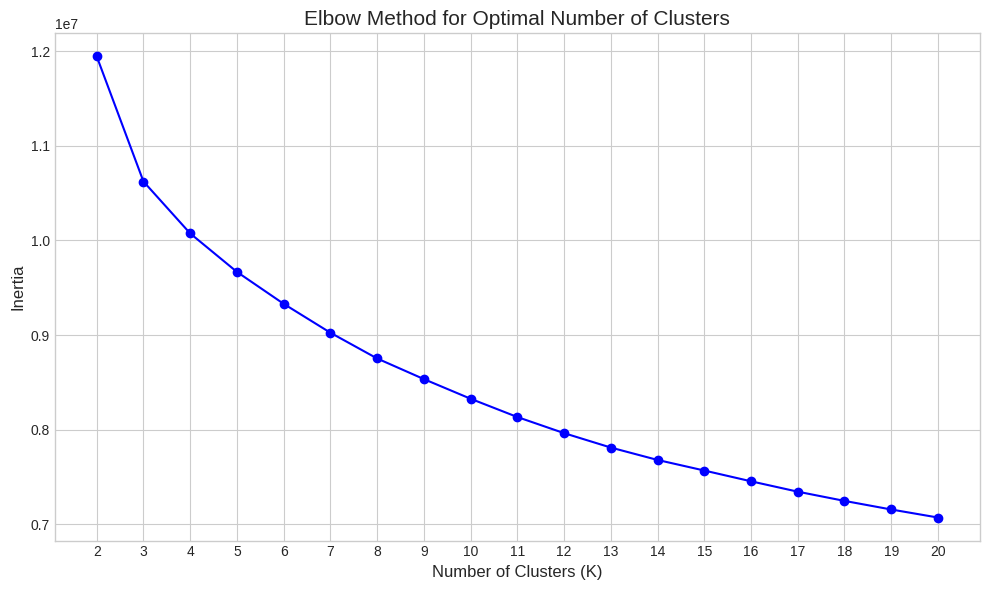

In [32]:
# Elbow method to choose number of clusters
print("\n=== Elbow Method for K-means ===")
inertias = []
k_range = range(2, 21)  # Test 2 to 20 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


=== Silhouette Scores ===
K=2, Silhouette Score=0.6427
K=3, Silhouette Score=0.6403
K=4, Silhouette Score=0.6419
K=5, Silhouette Score=0.6379
K=6, Silhouette Score=0.6404
K=7, Silhouette Score=0.6381
K=8, Silhouette Score=0.6403
K=9, Silhouette Score=0.6353
K=10, Silhouette Score=0.6418
K=11, Silhouette Score=0.6365
K=12, Silhouette Score=0.6393
K=13, Silhouette Score=0.6401
K=14, Silhouette Score=0.6396
K=15, Silhouette Score=0.6394
K=16, Silhouette Score=0.6380
K=17, Silhouette Score=0.6386
K=18, Silhouette Score=0.6370
K=19, Silhouette Score=0.6386
K=20, Silhouette Score=0.6410


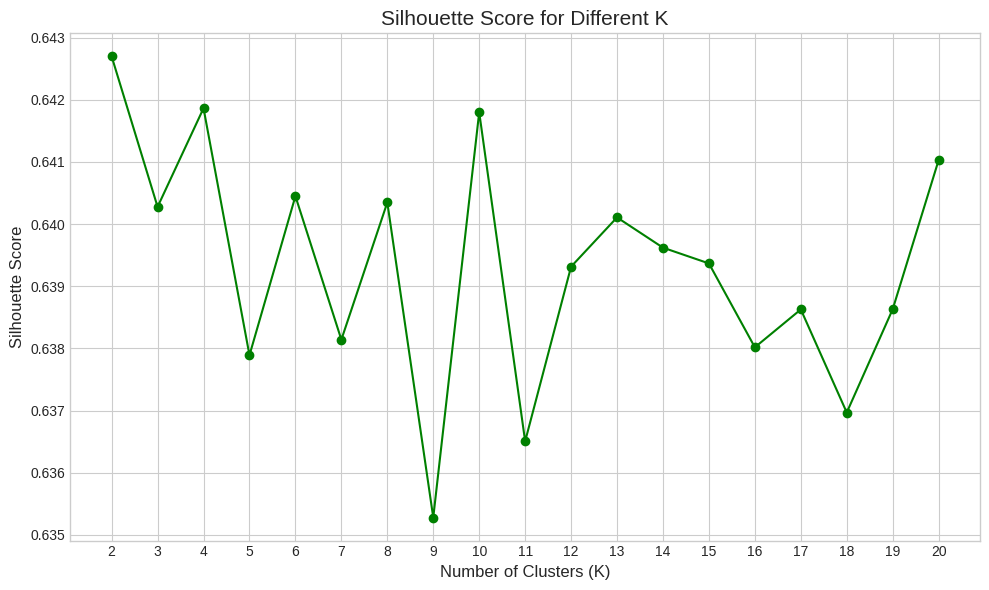

In [33]:
from sklearn.metrics import silhouette_score

# Silhouette score for validation
print("\n=== Silhouette Scores ===")
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters, sample_size=1000, random_state=42)  # Sample for speed
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Different K', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


=== Cluster Distribution ===
cluster
0    16900
1     5665
2     1085
3     3628
Name: count, dtype: int64

=== Cluster 0 ===
Number of movies: 16900
Sample movies:
     movieId                                              title  \
50        51                              Guardian Angel (1994)   
107      109                Headless Body in Topless Bar (1995)   
113      115  Happiness Is in the Field (Bonheur est dans le...   
122      124     Star Maker, The (Uomo delle stelle, L') (1995)   
125      127  Silences of the Palace, The (Saimt el Qusur) (...   
128      130                                      Angela (1995)   
131      133                                   Nueba Yol (1995)   
132      134                               Sonic Outlaws (1995)   
137      139                                      Target (1995)   
140      142                            Shadows (Cienie) (1988)   

                    genres    year  
50   Action|Drama|Thriller  1994.0  
107  Comedy|Drama|Thri

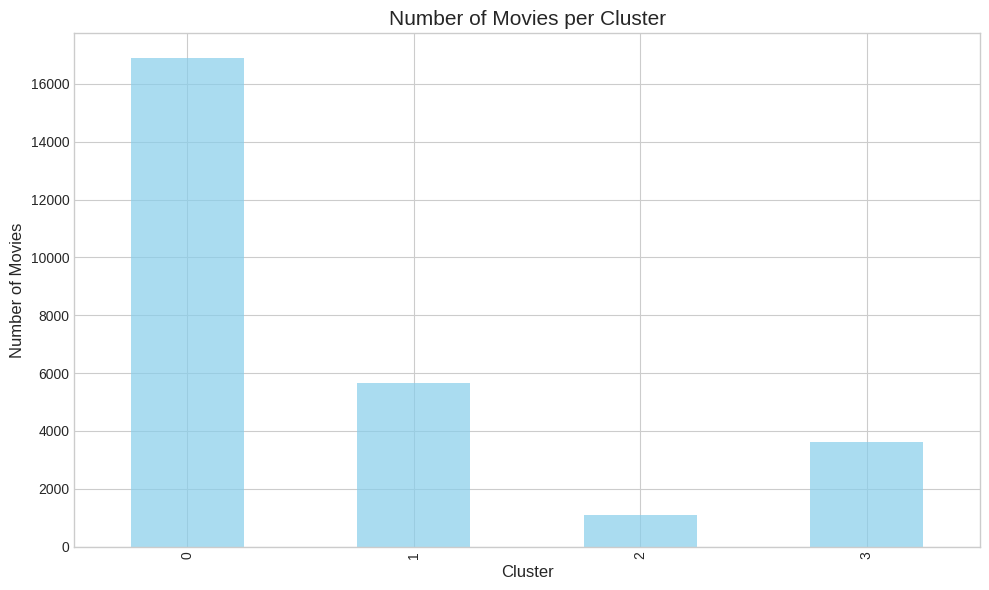

In [36]:
# Set plot style (consistent with previous snippets)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Apply K-means with k=6
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to feature_matrix and movie_df
feature_matrix['cluster'] = clusters
movie_df['cluster'] = feature_matrix['movieId'].map(dict(zip(feature_matrix['movieId'], clusters)))

# Print cluster distribution
print("\n=== Cluster Distribution ===")
print(movie_df['cluster'].value_counts().sort_index())

# Analyze clusters
for cluster in range(optimal_k):
    print(f"\n=== Cluster {cluster} ===")
    cluster_movies = movie_df[movie_df['cluster'] == cluster][['movieId', 'title', 'genres', 'year']]
    print(f"Number of movies: {len(cluster_movies)}")
    print("Sample movies:")
    print(cluster_movies.head(10))  # Show 10 movies for better insight

    # Top genres in cluster
    cluster_genres = Counter()
    for genres in cluster_movies['genres'].str.split('|'):
        cluster_genres.update(genres)
    print(f"Top 5 genres: {cluster_genres.most_common(5)}")

    # Top tags by average relevance
    cluster_movie_ids = cluster_movies['movieId']
    cluster_tags = genome_scores_df[genome_scores_df['movieId'].isin(cluster_movie_ids)]
    cluster_tags = cluster_tags.merge(genome_tags_df, on='tagId')
    top_tags = cluster_tags.groupby('tag')['relevance'].mean().sort_values(ascending=False).head(5)
    print(f"Top 5 tags by relevance: {top_tags}")

    # Rating statistics (merge with rating_stats from preparation)
    rating_stats = feature_matrix[feature_matrix['movieId'].isin(cluster_movie_ids)][['movieId', 'mean_rating', 'num_ratings']]
    print(f"Average rating: {rating_stats['mean_rating'].mean():.2f}")
    print(f"Average number of ratings: {rating_stats['num_ratings'].mean():.2f}")

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
movie_df['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Number of Movies per Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.tight_layout()
plt.show()

# Save results
movie_df.to_csv(base_path + 'movies_with_clusters.csv', index=False)

Explained variance ratio for 2 PCA components (sampled): 0.5828


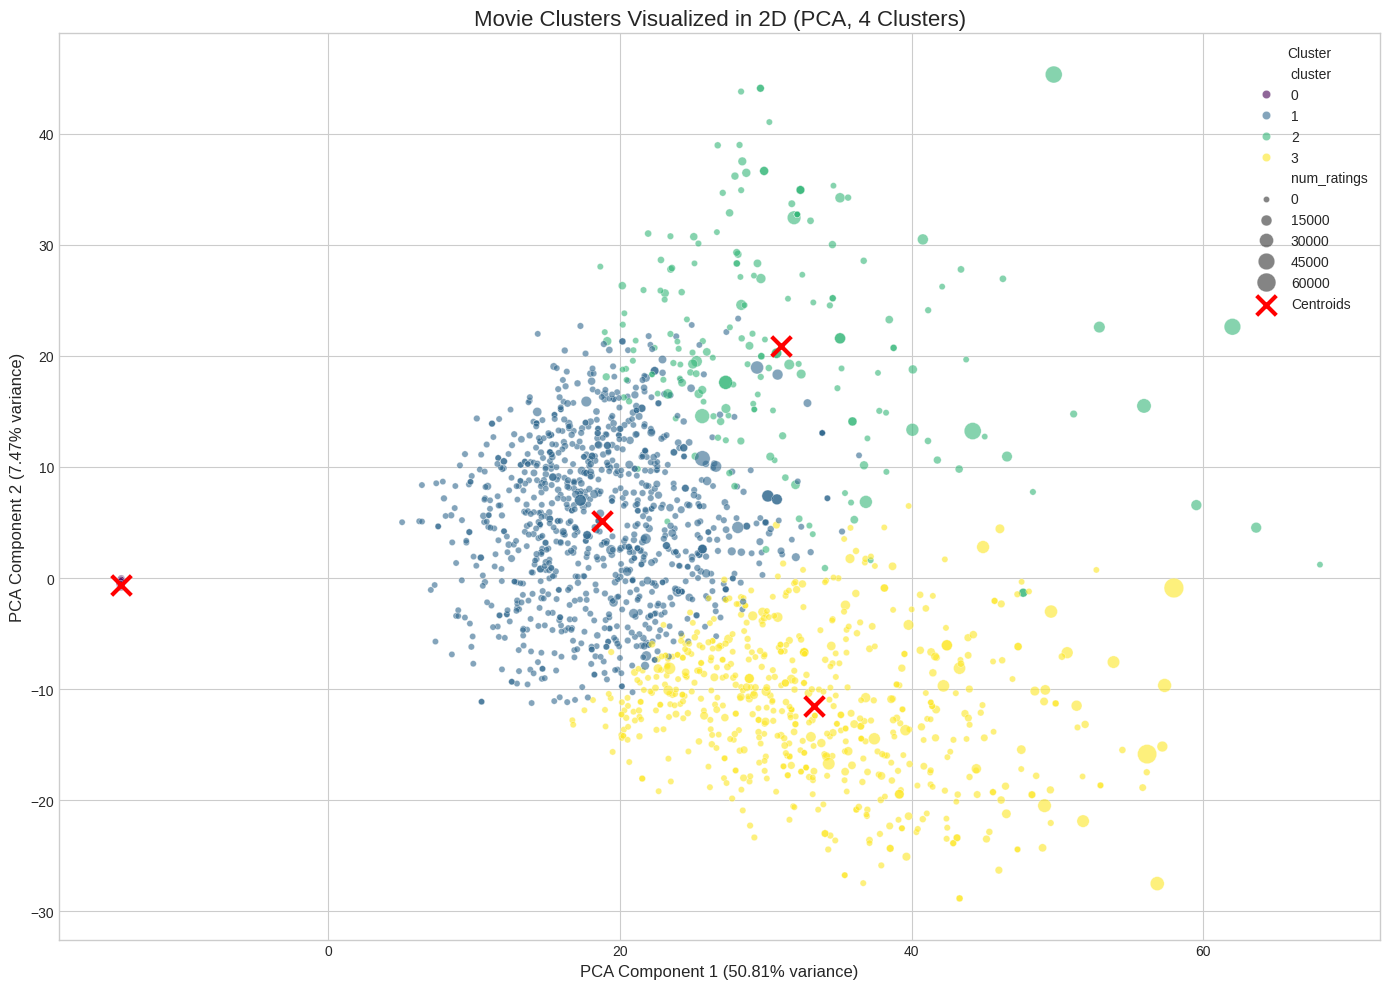


=== Cluster Analysis ===

=== Cluster 0 ===
Number of movies: 16900
Sample movies:
     movieId                                              title  \
50        51                              Guardian Angel (1994)   
107      109                Headless Body in Topless Bar (1995)   
113      115  Happiness Is in the Field (Bonheur est dans le...   
122      124     Star Maker, The (Uomo delle stelle, L') (1995)   
125      127  Silences of the Palace, The (Saimt el Qusur) (...   
128      130                                      Angela (1995)   
131      133                                   Nueba Yol (1995)   
132      134                               Sonic Outlaws (1995)   
137      139                                      Target (1995)   
140      142                            Shadows (Cienie) (1988)   

                    genres    year  
50   Action|Drama|Thriller  1994.0  
107  Comedy|Drama|Thriller  1995.0  
113                 Comedy  1995.0  
122                  Drama  19

In [43]:
# Sample movies to reduce clutter (optional, comment out to plot all)
np.random.seed(42)  # Set seed for reproducibility
sample_size = 5000  # Adjust as needed
sample_indices = np.random.choice(X_scaled.shape[0], size=sample_size)
X_scaled_sample = X_scaled[sample_indices]
feature_matrix_sample = feature_matrix.iloc[sample_indices]

# Apply PCA to sampled data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_sample)
print(f"Explained variance ratio for 2 PCA components (sampled): {pca.explained_variance_ratio_.sum():.4f}")

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'cluster': feature_matrix_sample['cluster'],
    'movieId': feature_matrix_sample['movieId'],
    'num_ratings': feature_matrix_sample['num_ratings']
})

# Plot clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=plot_df,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='viridis',
    alpha=0.6,
    size='num_ratings',
    sizes=(20, 200)
)
plt.title('Movie Clusters Visualized in 2D (PCA, 4 Clusters)', fontsize=16)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)

# Add cluster centroids
for cluster in range(4):
    centroid = X_pca[plot_df['cluster'] == cluster].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='x', s=200, c='red', linewidths=3, label='Centroids' if cluster == 0 else None)

plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.savefig(base_path + 'cluster_plot_k4_no_titles.png', dpi=300, bbox_inches='tight')
plt.show()

# Re-analyze clusters for context
print("\n=== Cluster Analysis ===")
optimal_k = 4
for cluster in range(optimal_k):
    print(f"\n=== Cluster {cluster} ===")
    cluster_movies = movie_df[movie_df['cluster'] == cluster][['movieId', 'title', 'genres', 'year']]
    print(f"Number of movies: {len(cluster_movies)}")
    print("Sample movies:")
    print(cluster_movies.head(10))

    # Top genres
    cluster_genres = Counter()
    for genres in cluster_movies['genres'].str.split('|'):
        cluster_genres.update(genres)
    print(f"Top 5 genres: {cluster_genres.most_common(5)}")

    # Top tags by relevance
    cluster_movie_ids = cluster_movies['movieId']
    cluster_tags = genome_scores_df[genome_scores_df['movieId'].isin(cluster_movie_ids)]
    cluster_tags = cluster_tags.merge(genome_tags_df, on='tagId')
    top_tags = cluster_tags.groupby('tag')['relevance'].mean().sort_values(ascending=False).head(5)
    print(f"Top 5 tags by relevance: {top_tags}")

    # Rating statistics
    rating_stats = feature_matrix[feature_matrix['movieId'].isin(cluster_movie_ids)][['movieId', 'mean_rating', 'num_ratings']]
    print(f"Average rating: {rating_stats['mean_rating'].mean():.2f}")
    print(f"Average number of ratings: {rating_stats['num_ratings'].mean():.2f}")